In [1]:
import os
import os.path as path
import gc
import re
import math
import json

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
pd.set_option('display.max_row', 50)
pd.set_option('display.max_columns', 100)

In [6]:
# 디렉토리 기본 경로 설정
DIR_PATH = path.join('..')
DIR_SAVE_PATH = path.join('.')

print(DIR_PATH)
print(DIR_SAVE_PATH)

..
.


In [7]:
# bean_raw_data.csv
user_read = pd.read_csv(path.join(DIR_PATH, 'user_propensity_data.csv'), low_memory=False)

print(user_read.shape)
user_read.columns = ['timestamp', 'phone', 'cafe', 'preference', 'drink', 'dessert', 'fruit', 'aroma']
user_read.head()

(105, 8)


,timestamp,phone,cafe,preference,drink,dessert,fruit,aroma
0,2023. 3. 24 오후 2:59:41,010-9491-7668,스타벅스 Starbucks,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"체리, 복숭아",허브의 마음이 진정되는 향기
1,2023. 3. 24 오후 3:03:33,010-2840-2336,스타벅스 Starbucks,다른 커피를 마실때보다 목넘김이 좋아요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",진하고 달달한 초코 케이크,"사과, 배",꿀이나 설탕같은 달달한 향기
2,2023. 3. 24 오후 3:03:50,010-9231-9670,투썸플레이스 A TWOSOME PLACE,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",상큼하고 개운한 과일 타르트,"크랜베리, 블루베리",허브의 마음이 진정되는 향기
3,2023. 3. 24 오후 3:04:09,010-9027-0157,이디야 커피 EDIYA COFFEE,다른 커피를 마실때보다 목넘김이 좋아요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"레몬, 오렌지, 귤",나무의 우디한 향기
4,2023. 3. 24 오후 3:04:13,010-4404-9238,스타벅스 Starbucks,설탕이나 초콜릿 냄새라던가 맛이 선명해요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",상큼하고 개운한 과일 타르트,"사과, 배",꽃의 신선한 향기


In [19]:
user_data = user_read.iloc[:, 2:].copy()
user_data

,cafe,preference,drink,dessert,fruit,aroma
0,스타벅스 Starbucks,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"체리, 복숭아",허브의 마음이 진정되는 향기
1,스타벅스 Starbucks,다른 커피를 마실때보다 목넘김이 좋아요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",진하고 달달한 초코 케이크,"사과, 배",꿀이나 설탕같은 달달한 향기
2,투썸플레이스 A TWOSOME PLACE,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",상큼하고 개운한 과일 타르트,"크랜베리, 블루베리",허브의 마음이 진정되는 향기
3,이디야 커피 EDIYA COFFEE,다른 커피를 마실때보다 목넘김이 좋아요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"레몬, 오렌지, 귤",나무의 우디한 향기
4,스타벅스 Starbucks,설탕이나 초콜릿 냄새라던가 맛이 선명해요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",상큼하고 개운한 과일 타르트,"사과, 배",꽃의 신선한 향기
...,...,...,...,...,...,...
100,컴포즈,커피의 새콤한 맛이 도드라져요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"레몬, 오렌지, 귤",꽃의 신선한 향기
101,이디야 커피 EDIYA COFFEE,커피 특유의 씁쓸한 맛이 잘 나타나요,"☕에스프레소 또는 아메리카노, 콜드브루",상큼하고 개운한 과일 타르트,"레몬, 오렌지, 귤",나무의 우디한 향기
102,카페 파스쿠치 CAFFÉ PASCUCCI,다른 커피를 마실때보다 목넘김이 좋아요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"크랜베리, 블루베리",나무의 우디한 향기
103,투썸플레이스 A TWOSOME PLACE,커피의 새콤한 맛이 도드라져요,"☕에스프레소 또는 아메리카노, 콜드브루",담백하고 고소한이 두드러지는 호두파이,"망고, 바나나, 파인애플",허브의 마음이 진정되는 향기


In [24]:
user_data.loc[(user_data['cafe'] != '스타벅스 Starbucks') \
& (user_data['cafe'] != '투썸플레이스 A TWOSOME PLACE') \
& (user_data['cafe'] != '이디야 커피 EDIYA COFFEE') \
& (user_data['cafe'] != '카페 파스쿠치 CAFFÉ PASCUCCI'), 'cafe'] = "_기타"
user_data

,cafe,preference,drink,dessert,fruit,aroma
0,스타벅스 Starbucks,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"체리, 복숭아",허브의 마음이 진정되는 향기
1,스타벅스 Starbucks,다른 커피를 마실때보다 목넘김이 좋아요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",진하고 달달한 초코 케이크,"사과, 배",꿀이나 설탕같은 달달한 향기
2,투썸플레이스 A TWOSOME PLACE,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",상큼하고 개운한 과일 타르트,"크랜베리, 블루베리",허브의 마음이 진정되는 향기
3,이디야 커피 EDIYA COFFEE,다른 커피를 마실때보다 목넘김이 좋아요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"레몬, 오렌지, 귤",나무의 우디한 향기
4,스타벅스 Starbucks,설탕이나 초콜릿 냄새라던가 맛이 선명해요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",상큼하고 개운한 과일 타르트,"사과, 배",꽃의 신선한 향기
...,...,...,...,...,...,...
100,_기타,커피의 새콤한 맛이 도드라져요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"레몬, 오렌지, 귤",꽃의 신선한 향기
101,이디야 커피 EDIYA COFFEE,커피 특유의 씁쓸한 맛이 잘 나타나요,"☕에스프레소 또는 아메리카노, 콜드브루",상큼하고 개운한 과일 타르트,"레몬, 오렌지, 귤",나무의 우디한 향기
102,카페 파스쿠치 CAFFÉ PASCUCCI,다른 커피를 마실때보다 목넘김이 좋아요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"크랜베리, 블루베리",나무의 우디한 향기
103,투썸플레이스 A TWOSOME PLACE,커피의 새콤한 맛이 도드라져요,"☕에스프레소 또는 아메리카노, 콜드브루",담백하고 고소한이 두드러지는 호두파이,"망고, 바나나, 파인애플",허브의 마음이 진정되는 향기


In [91]:
cafe_list = np.sort(user_data['cafe'].unique()).tolist()
print(cafe_list)

if 'cafe_label' in user_data:
    user_data.drop(labels=['cafe_label'], axis=1, inplace=True)

# user_data.insert(int(user_data.columns.get_indexer(['cafe'])[0] + 1), 'cafe_label', user_data['cafe'].map(lambda x: cafe_list.index(x)), )
user_data.insert(len(user_data.columns), 'cafe_label', user_data['cafe'].map(lambda x: cafe_list.index(x)))

['_기타', '스타벅스 Starbucks', '이디야 커피 EDIYA COFFEE', '카페 파스쿠치 CAFFÉ PASCUCCI', '투썸플레이스 A TWOSOME PLACE']


In [92]:
preference_list = np.sort(user_data['preference'].unique()).tolist()
print(preference_list)

if 'preference_label' in user_data:
    user_data.drop(labels=['preference_label'], axis=1, inplace=True)

user_data.insert(len(user_data.columns), 'preference_label', user_data['preference'].map(lambda x: preference_list.index(x)))

['다른 커피를 마실때보다 목넘김이 좋아요', '설탕이나 초콜릿 냄새라던가 맛이 선명해요', '커피 특유의 씁쓸한 맛이 잘 나타나요', '커피의 새콤한 맛이 도드라져요', '향이나 맛이 다른 커피보다 잘 느껴져요']


In [93]:
drink_list = np.sort(user_data['drink'].unique()).tolist()
print(drink_list)

if 'drink_label' in user_data:
    user_data.drop(labels=['drink_label'], axis=1, inplace=True)

user_data.insert(len(user_data.columns), 'drink_label', user_data['drink'].map(lambda x: drink_list.index(x)))

['☕에스프레소 또는 아메리카노, 콜드브루', '🌸티 또는 주스', '🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)', '🥛카페라떼 또는 카푸치노, 마끼아또 (달지않아요)']


In [94]:
dessert_list = np.sort(user_data['dessert'].unique()).tolist()
print(dessert_list)

if 'dessert_label' in user_data:
    user_data.drop(labels=['dessert_label'], axis=1, inplace=True)

user_data.insert(len(user_data.columns), 'dessert_label', user_data['dessert'].map(lambda x: dessert_list.index(x)))

['담백하고 고소한이 두드러지는 호두파이', '상큼하고 개운한 과일 타르트', '진하고 달달한 초코 케이크']


In [95]:
fruit_list = np.sort(user_data['fruit'].unique()).tolist()
print(fruit_list)

if 'fruit_label' in user_data:
    user_data.drop(labels=['fruit_label'], axis=1, inplace=True)

user_data.insert(len(user_data.columns), 'fruit_label', user_data['fruit'].map(lambda x: fruit_list.index(x)))

['레몬, 오렌지, 귤', '망고, 바나나, 파인애플', '사과, 배', '체리, 복숭아', '크랜베리, 블루베리']


In [96]:
aroma_list = np.sort(user_data['aroma'].unique()).tolist()
print(aroma_list)

if 'aroma_label' in user_data:
    user_data.drop(labels=['aroma_label'], axis=1, inplace=True)

user_data.insert(len(user_data.columns), 'aroma_label', user_data['aroma'].map(lambda x: aroma_list.index(x)))

['감귤의 상큼한 향기', '꽃의 신선한 향기', '꿀이나 설탕같은 달달한 향기', '나무의 우디한 향기', '허브의 마음이 진정되는 향기']


In [97]:
user_data.head()

,cafe,preference,drink,dessert,fruit,aroma,cafe_label,preference_label,drink_label,dessert_label,fruit_label,aroma_label
0,스타벅스 Starbucks,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"체리, 복숭아",허브의 마음이 진정되는 향기,1,4,0,2,3,4
1,스타벅스 Starbucks,다른 커피를 마실때보다 목넘김이 좋아요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",진하고 달달한 초코 케이크,"사과, 배",꿀이나 설탕같은 달달한 향기,1,0,2,2,2,2
2,투썸플레이스 A TWOSOME PLACE,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",상큼하고 개운한 과일 타르트,"크랜베리, 블루베리",허브의 마음이 진정되는 향기,4,4,0,1,4,4
3,이디야 커피 EDIYA COFFEE,다른 커피를 마실때보다 목넘김이 좋아요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"레몬, 오렌지, 귤",나무의 우디한 향기,2,0,0,2,0,3
4,스타벅스 Starbucks,설탕이나 초콜릿 냄새라던가 맛이 선명해요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",상큼하고 개운한 과일 타르트,"사과, 배",꽃의 신선한 향기,1,1,2,1,2,1


In [99]:
user_label = user_data.iloc[:, 6:].copy()
user_label.head()

,cafe_label,preference_label,drink_label,dessert_label,fruit_label,aroma_label
0,1,4,0,2,3,4
1,1,0,2,2,2,2
2,4,4,0,1,4,4
3,2,0,0,2,0,3
4,1,1,2,1,2,1


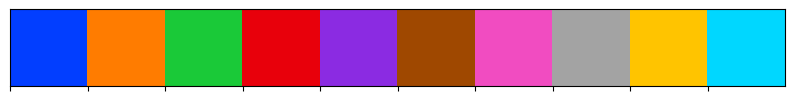

In [109]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.palplot(sns.color_palette("bright"))


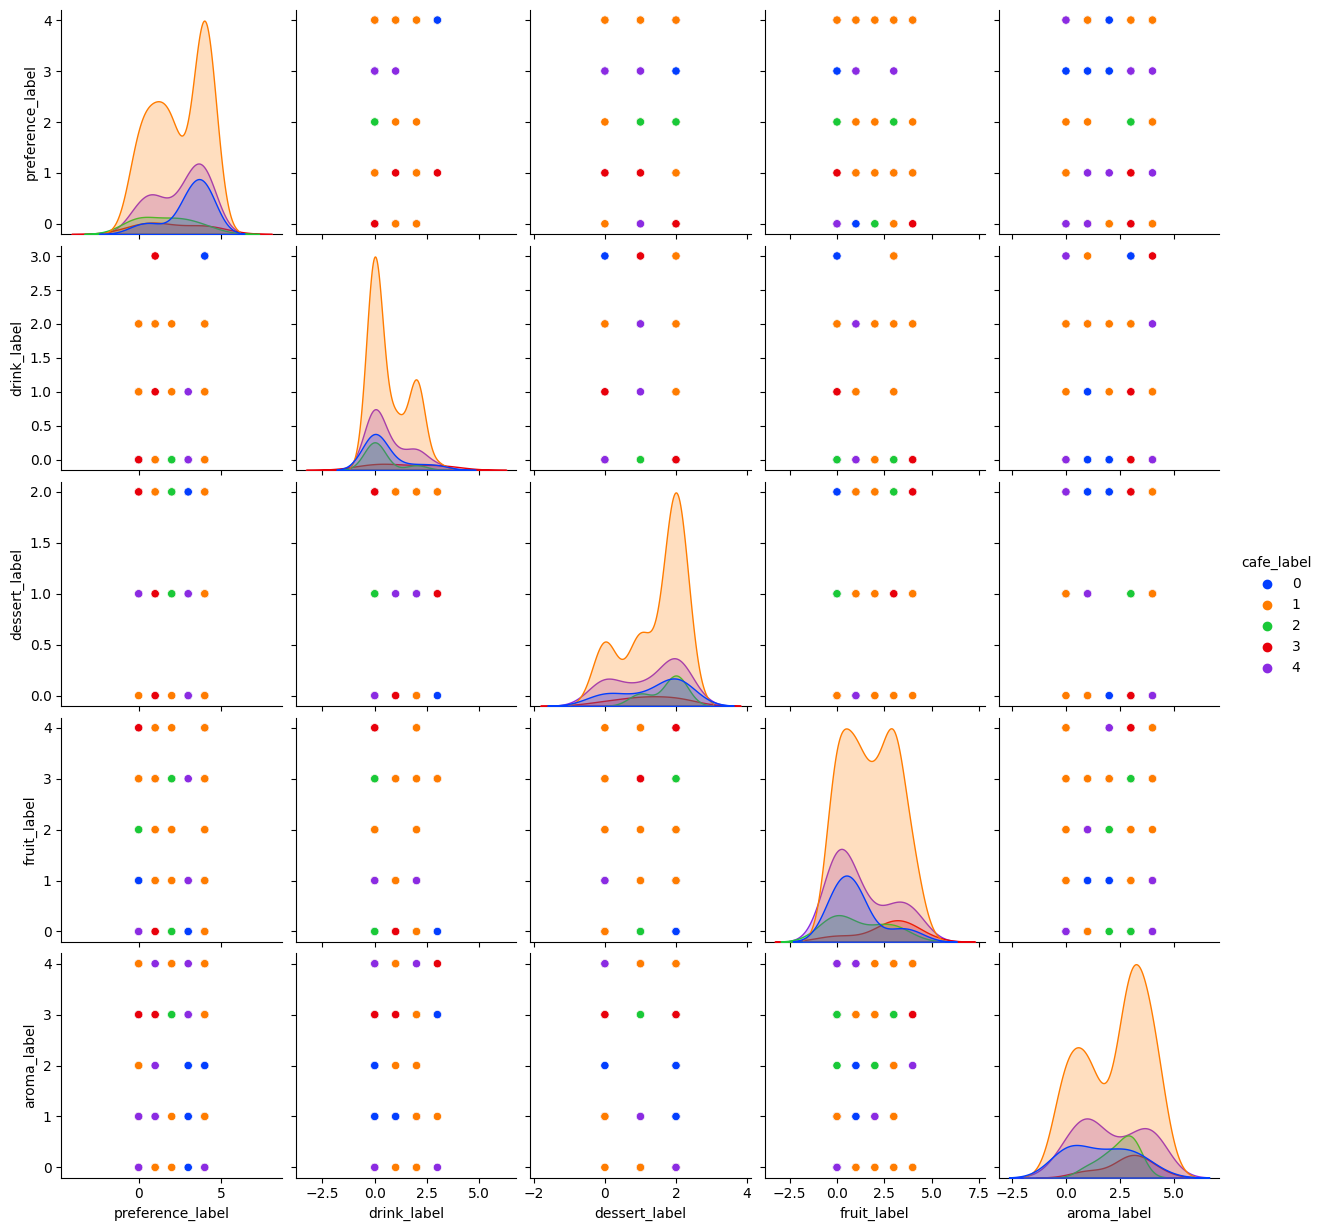

In [113]:
sns.pairplot(user_label, hue='cafe_label', palette='bright')

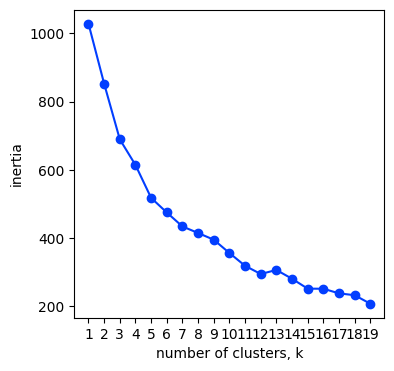

In [116]:
from sklearn.cluster import KMeans
# 적절한 군집수 찾기
# Inertia(군집 내 거리제곱합의 합) value (적정 군집수)

ks = range(1,20)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k, n_init='auto')
    model.fit(user_label)
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.figure(figsize=(4, 4))

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [118]:
# K-Means 모델과 군집 예측값을 생성

# 클러스터 모델 생성 파라미터는 원할 경우 추가
clust_model = KMeans(n_clusters = 5, n_init='auto'
#                      , max_iter=500 # KMeans를 몇번 반복 수행할건지, K가 큰 경우 1000정도로 높여준다
#                      , random_state = 42
#                      , algorithm='auto'
                    )

# 생성한 모델로 데이터를 학습시킴
clust_model.fit(user_label) # unsupervised learning 

# 결과 값을 변수에 저장
centers = clust_model.cluster_centers_ # 각 군집의 중심점
pred = clust_model.predict(user_label) # 각 예측군집

print(pd.DataFrame(centers))
print(pred[:10])

          0         1         2         3         4         5
0  2.315789  3.842105  0.157895  1.157895  2.578947  1.210526
1  1.393939  3.272727  0.121212  1.242424  1.030303  3.393939
2  0.941176  1.235294  0.941176  1.588235  1.058824  0.294118
3  2.038462  0.615385  0.923077  1.615385  2.038462  2.692308
4  1.400000  4.000000  2.300000  1.400000  1.100000  2.000000
[1 3 0 3 2 1 1 0 3 1]


In [119]:
# 원래 데이터에 예측된 군집 붙이기
user_clust_df = user_label.copy()
user_clust_df['clust'] = pred
user_clust_df.head()

,cafe_label,preference_label,drink_label,dessert_label,fruit_label,aroma_label,clust
0,1,4,0,2,3,4,1
1,1,0,2,2,2,2,3
2,4,4,0,1,4,4,0
3,2,0,0,2,0,3,3
4,1,1,2,1,2,1,2


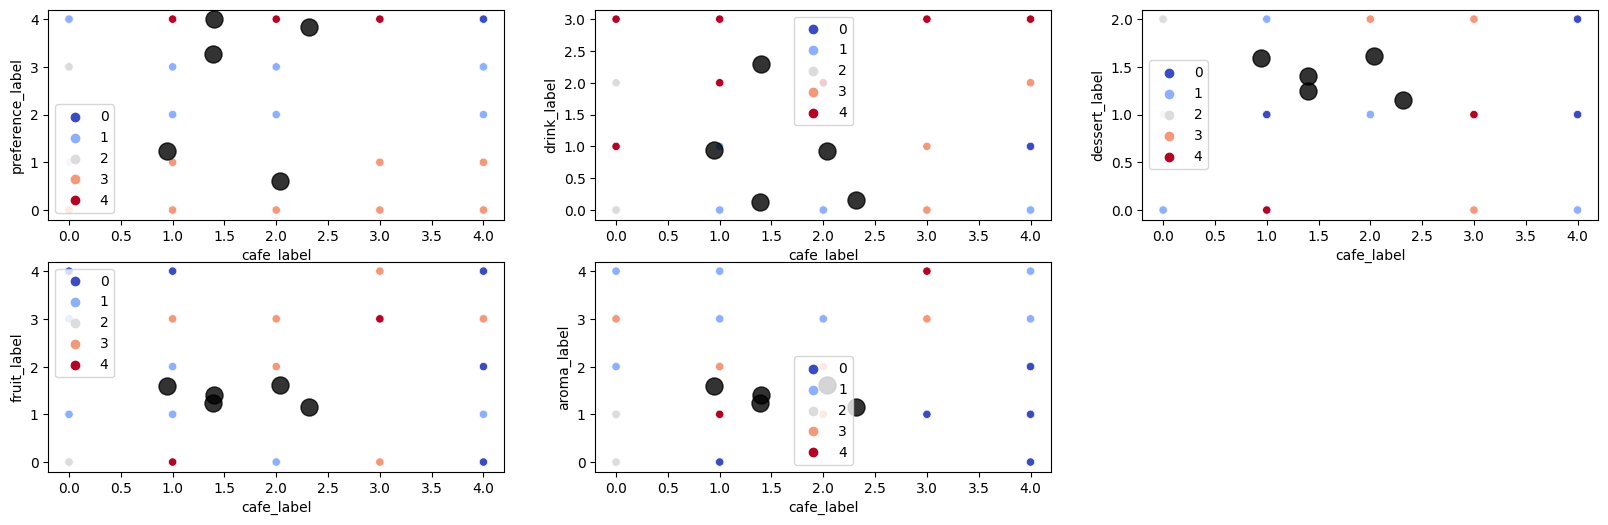

In [122]:
# scaling하지 않은 데이터를 학습하고 시각화하기

plt.figure(figsize=(20, 6))

X = user_clust_df

plt.subplot(231)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,1], data=user_label, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,1], c='black', alpha=0.8, s=150)

plt.subplot(232)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,2], data=user_label, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,2], c='black', alpha=0.8, s=150)

plt.subplot(233)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,3], data=user_label, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,3], c='black', alpha=0.8, s=150)

plt.subplot(234)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,4], data=user_label, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,3], c='black', alpha=0.8, s=150)

plt.subplot(235)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,5], data=user_label, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,3], c='black', alpha=0.8, s=150)

plt.show()

In [123]:
cluster_mean = user_clust_df.groupby('clust').mean()
cluster_mean

,cafe_label,preference_label,drink_label,dessert_label,fruit_label,aroma_label
clust,,,,,,
0,2.315789,3.842105,0.157895,1.157895,2.578947,1.210526
1,1.393939,3.272727,0.121212,1.242424,1.030303,3.393939
2,0.941176,1.235294,0.941176,1.588235,1.058824,0.294118
3,2.038462,0.615385,0.923077,1.615385,2.038462,2.692308
4,1.400000,4.000000,2.300000,1.400000,1.100000,2.000000


In [130]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
scaled_df = pd.DataFrame(standard_scaler.fit_transform(user_label.iloc[:,:]), columns=user_label.iloc[:,:].columns) # scaled된 데이터

In [131]:
# create model and prediction
# clust_model은 스케일링 전 fit과 동일하게 맞춤

clust_model.fit(scaled_df) # unsupervised learning #애초에 결과를 모르기 때문에 data만 넣어주면 됨

centers_s = clust_model.cluster_centers_
pred_s = clust_model.predict(scaled_df)

In [132]:
# 스케일링 전에 합쳐준 데이터프레임에 스케일한 군집 컬럼 추가하기
user_clust_df['clust_s'] = pred_s
user_clust_df

,cafe_label,preference_label,drink_label,dessert_label,fruit_label,aroma_label,clust,clust_s
0,1,4,0,2,3,4,1,1
1,1,0,2,2,2,2,3,4
2,4,4,0,1,4,4,0,0
3,2,0,0,2,0,3,3,2
4,1,1,2,1,2,1,2,4
...,...,...,...,...,...,...,...,...
100,0,3,0,2,0,1,2,1
101,2,2,0,1,0,3,1,2
102,3,0,0,2,4,3,3,2
103,4,3,0,0,1,4,1,0


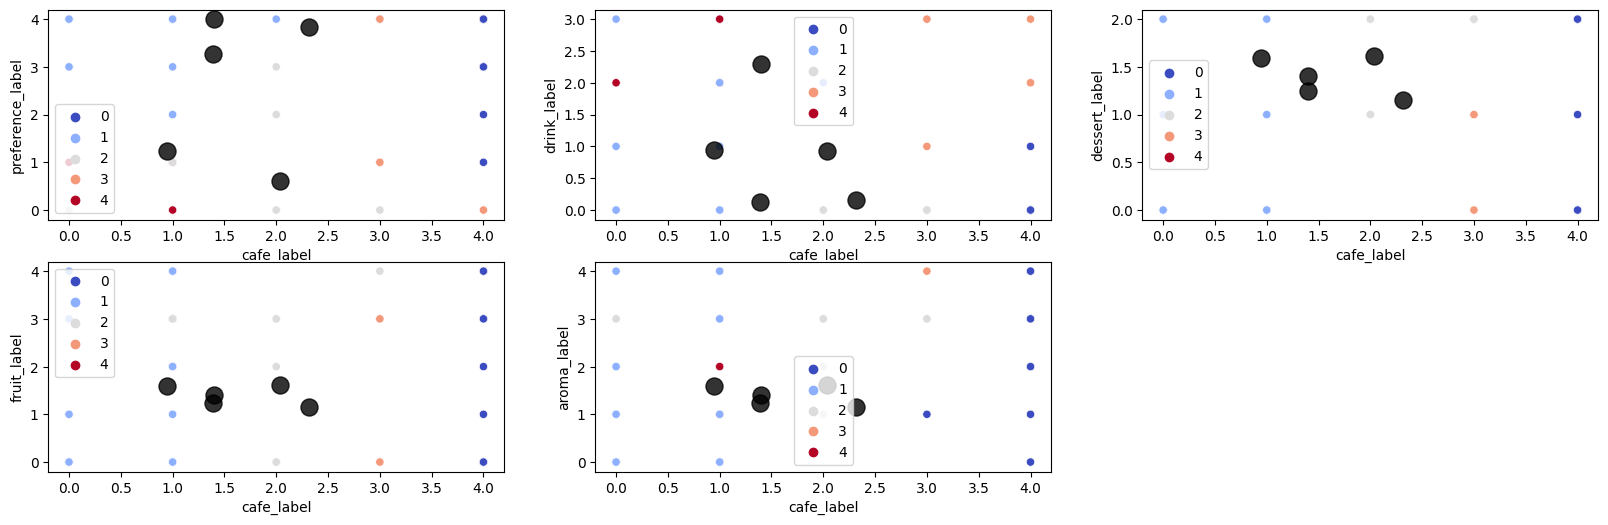

In [133]:
# scaling한 데이터를 학습하고 시각화하기

plt.figure(figsize=(20, 6))

X = user_clust_df

plt.subplot(231)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,1], data=user_label, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,1], c='black', alpha=0.8, s=150)

plt.subplot(232)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,2], data=user_label, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,2], c='black', alpha=0.8, s=150)

plt.subplot(233)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,3], data=user_label, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,3], c='black', alpha=0.8, s=150)

plt.subplot(234)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,4], data=user_label, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,3], c='black', alpha=0.8, s=150)

plt.subplot(235)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,5], data=user_label, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,3], c='black', alpha=0.8, s=150)

plt.show()

In [207]:
weight_df = pd.DataFrame(columns=['flavor', 'acidity', 'sweetness', 'bitterness', 'body', 'balance'], dtype='float')
# weight_df = weight_df.astype({'coffeeing_note':'str'})
print(weight_df.dtypes)
weight_df.head()

flavor        float64
acidity       float64
sweetness     float64
bitterness    float64
body          float64
balance       float64
dtype: object


,flavor,acidity,sweetness,bitterness,body,balance


In [208]:
survey_weight_df = []
for i in range(5):
    survey_weight_df.append(weight_df.copy())

In [209]:
survey_weight_df[0]

,flavor,acidity,sweetness,bitterness,body,balance


In [210]:
tmp_list = [0, 0, 0, 0, 0, 0]
tmp_list = [x + y for x, y in zip(tmp_list, [1,1,1,1,1,1])]
tmp_list = [x + y for x, y in zip(tmp_list, [2,1,1,1,0,2])]
tmp_list = [x + y for x, y in zip(tmp_list, [1,1,1,2,1,1])]
tmp_list = [x + y for x, y in zip(tmp_list, [2,0,1,1,0,2])]
tmp_list = [x + y for x, y in zip(tmp_list, [1,1,0,2,0,1])]
tmp_list = [x + y for x, y in zip(tmp_list, [])]
tmp_list = [x + y for x, y in zip(tmp_list, [])]

KeyError: 1

In [211]:
clust_model.feature_importances_

AttributeError: 'KMeans' object has no attribute 'feature_importances_'